# Lab 4.1:  Decision Trees

Decision trees can be used for either regression or classification tasks. Decision trees are a powerful tool; however, are very prone to overfitting the training dataset and therefore often fail to generalize well to test data sets. However, they are the building block for several other powerful machine learning algorithms and are therefore important to learn about.

<img src="../images/DecisionTreeExample.png" alt="Drawing" style="width: 500px;height=500"/>

Here's a look ahead at what we'll be doing in this notebook:

1. [Import packages](#packages)
2. [Load data](#loaddata)
3. [Build a Decision Tree](#decisiontree)
4. [Tune parameters](#parameters)
5. [Feature Importance](#featureimportance)
6. [Homework](#homework)
7. [Advanced Material](#AdvancedCV)

Our previous Linear regression model was a parametric model which assumes linearity among others.

Whereas decision trees and associated algorithms are non-parametric models which means we are no longer restricted to independant variables which have a linear relationship and we don't have to ensure several assumptions are true. 

Therefore we can start to bring in other features that could be useful.

After we run our decision trees, we will compare our new output to our output from the linear regressions we ran in the previous notebook. 

In this notebook, we will be looking at how we can predict the loan amount using decision trees. 

Here is visual introduction to [decision trees](https://algobeans.com/2016/07/27/decision-trees-tutorial/)

## 1. Import packages
<a id='packages'></a>

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from ggplot import *
plt.style.use('ggplot')
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
import graphviz 
from sklearn import tree

If you do not have graphviz installed or are having problems displaying the tree structure later on, try:

Mac/Windows:

```bash
$ brew install graphviz 
```

Linux:

```
$ sudo apt-get install graphviz
```

## 2. Load and format data
<a id='loaddata'></a>

In [3]:
# Load data to pandas DataFrame
data_path = '../data/'
df = pd.read_csv(data_path+'df_end_of_linear.csv', low_memory=False)

In [4]:
# TODO: Remove this part and incorporate it into feature engineering section.
# potentially the feature engineering section should show how to do one hot encoding and this module
# will reference one hot encoding and remove any cols that are strings to highligh that sklearn's implementation
# cannot handle strings.
df = df.dropna()
cols = df[['loan_amount', 
           'partner_delinquency_rate',
            'posted_year',
           'posted_month',
           'female',
           'num_tags',
           'parent',
           'tag_#Woman Owned Biz',
           'age_int',
           'tag_#Repeat Borrower',
           'children_int',
          'more_one_partner_country',
          'terms.repayment_term',
           'tag_#Schooling',
           'married',
           'pct_female',
           'exploratory_partner',
           'partner_dollar_amount',
           'top_partner_id',
           'num_partner_countries',
           'days_to_fund',
            'hours_to_fund',
            'bc_partner_others',
           'bc_partner_HIHEA',
           'bc_partner_OAF_high',
           'bc_partner_OAF_low',
         'sector_Personal Use',
           'sector_Health',
           'sector_Wholesale',
           'sector_Agriculture',
           'kids']]


Just like last module, we are going to build regressors to predict the loan amount.

However, instead of using just a few features, we will build a tree that considers many the features in the dataset - including those we have engineered ourselves.

In [5]:
y = df['loan_amount']
# drop returns a copy of the DataFrame with the specified columns removed.  
X = cols.drop('loan_amount', axis=1)

In [6]:
# Split data into training and testing sets;
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 3. Build a Decision Tree
<a id='decisiontree'></a>
Before we build our first decision tree, let's first learn about the input parameters for sklearn's implementation of a Decision Tree Regressor.  

Feel free to look at the [docs](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor.get_params), or simply put a question mark before a call to the class.  Prepending a ? to any method, variable, or class will display that method's defined docstring (way to go ipython!)

In [7]:
?DecisionTreeRegressor

Many of the sklearn algorithms are implemented using the same standard steps: 
- **Step 1: Initiate the algorithm** Tdefine the parameters (& hyperparameters of the algorithm) of the algorithm. For example, the maximum depth, the minimum samples in a leaf etc. To learn more about the parameters for each algorithm, either check the module documentation on the internet or run a cell with the algorithm name followed by ? as we did at the beginning of this notebook for the RandomForestRegressor. These resources will also tell you the default values used for each parameter. 

- **Step 2: Train the algorithm** train the algorithm by fitting it to the X_train and y_train datasets.

- **Step 3: Evaluating the algorithm** evaluate the predictive power of the algorithm by comparing the predictive loan amount values to the true values. We can do this for the training and testing dataset.

First let build a function which encapsulates the 3 model implementation steps; Initialize, Train, Evaluate our decision tree regressor. 

In [7]:
def train_score_regressor(sklearn_regressor, X_train, y_train, X_test, y_test, model_parameters):
    '''
    Purpose: 
        - train a regressor on training data
        - score data on training and test data
        - return trained model
    '''
    # Step 1: Initializing the sklearn regressor 
    regressor = sklearn_regressor(**model_parameters)
    
    # Step 2: Training the algorithm using the X_train dataset of features and y_train, the associated target features
    regressor.fit(X_train, y_train)
    
    # Step 3: Calculating the score of the predictive power on the training and testing dataset.
    training_score = regressor.score(X_train, y_train)
    testing_score = regressor.score(X_test, y_test)
    
    # Print the results!
    print(f"Train score: {training_score:.4}")
    print(f"Test score: {testing_score:.4}")
        
    return regressor

With all tree algorithms the major challenge is using the parameters to balance the bias vs variance tradeoff.  

Before we get into exploring the parameters, let's see how the model preforms when using the default values.

In [12]:
trained_regressor = train_score_regressor(sklearn_regressor = DecisionTreeRegressor,
                                          X_train = X_train, y_train = y_train, 
                                          X_test = X_test, y_test = y_test, 
                                          model_parameters = {'random_state':42})

Train score: 1.0
Test score: 0.363635374266


While the Decision Tree managed to get a perfect r2 scored on the training data, it managed an abysmal .34 on the test data.  This is a clear indication that the model has overfit the data.

Given that by default sklearn's implementation of a DecisionTreeRegressor does not put any restrictions on the depth of the tree, the number of samples per leaf, the number of samples per leaf, etc.  As a result, the Decision Tree will find signal in any and all noise of the training data set, which causes the model to perform poorly on the test data.  

When a model overfits to a training data set, we say it has **high variance**.  Since an unconstrained decision tree will almost perfectly model any training data, it will vary tremendously depending on the training data that is provided.

### 4. Parameter tuning
To reduce the variance, we constrain the model using some of the provided parameters for example:
- Criterion (Cost function used to measure the purity of a split)
- Maximum depth of the tree
- Minimum samples for each node split
- Minimum samples for each terminal node
- Maximum number of terminal nodes

If you need a refresher to remember what these parameters are, look back over the [slides](https://docs.google.com/presentation/d/1leWPbwis9GJHJcQehlhPhtKEAErUPvlTpKjnkv1aWWU/edit?usp=sharing) or use this [useful blog](https://www.analyticsvidhya.com/blog/2016/04/complete-tutorial-tree-based-modeling-scratch-in-python/#four).

Initially, we are going to experiment with the max_depth parameter. 

In [14]:
# Define the model parameters 
# We are fixing the random state so that the results are reproducible and consistent.
parameters = {"max_depth":4,'random_state':42}
trained_regressor = train_score_regressor(sklearn_regressor = DecisionTreeRegressor,
                                          X_train = X_train, y_train = y_train, 
                                          X_test = X_test, y_test = y_test, 
                                          model_parameters = parameters)

Train score: 0.558032781957
Test score: 0.438339906714


Although the training r2 score plummeted down to .54, the test r2 score increased to .44, and since the goal is develop a model that accurately predict data we have never seen, that is the data we care about!

Now that we have increased preformance, let's take a look at what the Decision Tree looks like.

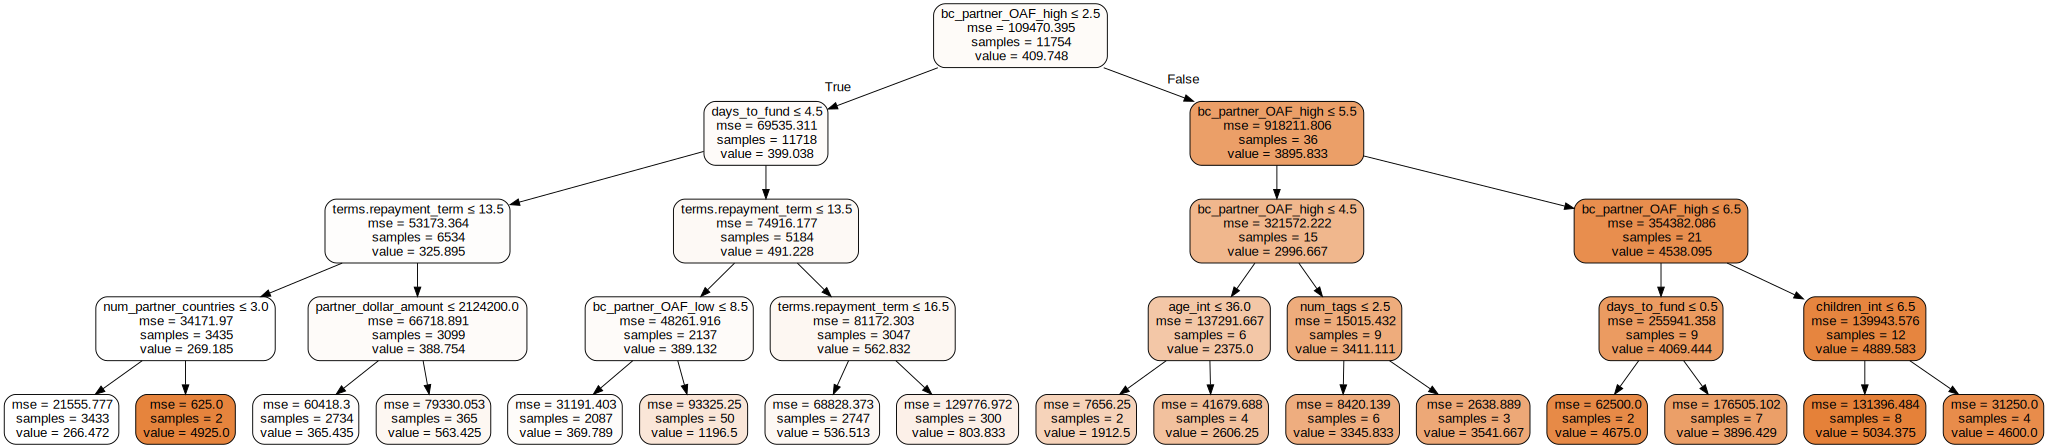

In [15]:
# from the sklearn tree library, create image of trained decision tree
dot_data = tree.export_graphviz(trained_regressor, out_file=None, 
                         feature_names=X_train.columns,  
                         class_names=y_train.values,  
                         filled=True, rounded=True,  
                         special_characters=True) 
# use graphviz to render the image
graph = graphviz.Source(dot_data) 
graph

A DecisionTreeRegressor with a max depth of only 4 is still rather complicated. To develop your intuition for the various input parameters, manually adjust them up and down to see the impacts.

Overall we're aiming for the highest predictive power on the test set. However, if you were to tune the parameters manually and tune towards a higher score on the test data set, you would most likely be overfitting to this specific test data set and the model would not generalize well to a secondary test data set.  

To avoid this, it is recommended that you use k-fold validation. In addition to k-fold validation, we will use sklearn's GridSearchCV, which allows us using k-fold validation to assess every permuation of possible values for the parameters that we provide. See the [Advanced Material](#AdvancedCV) at the bottom of this notebook for a quick overview of these two methods.

**Note** since we are training one regressor one time for each possible permutation of specified parameter values, this next cell will take some time to run.  That is why you need to gain an intuition for which values to test!

In [24]:
parameters = {'max_depth':[8,10,14], 
              'min_impurity_decrease': [.1,.01, 0.0],
              'min_samples_split': [10, 50, 2]}
decision_regressor= DecisionTreeRegressor(random_state=42)
regressor = GridSearchCV(decision_regressor, parameters)
regressor.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'min_samples_split': [10, 50, 2], 'min_impurity_decrease': [0.1, 0.01, 0.0], 'max_depth': [8, 10, 14]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [25]:
# print out what GridSearchCV found to be the best parameters 
regressor.best_estimator_.get_params()

{'criterion': 'mse',
 'max_depth': 8,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.1,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'min_weight_fraction_leaf': 0.0,
 'presort': False,
 'random_state': 42,
 'splitter': 'best'}

In [26]:
# evaluate the tuned model
trained_regressor = train_score_regressor(sklearn_regressor = DecisionTreeRegressor,
                                          X_train = X_train, y_train = y_train, 
                                          X_test = X_test, y_test = y_test, 
                                          model_parameters = regressor.best_estimator_.get_params())

Train score: 0.689422398154
Test score: 0.569229316572


Performance on the test data has increased from 0.43 to 0.56 - not bad!

The R^2 number above is pretty telling but it is always nice to visualise how these look in a scattor plot. This allows us to visualise the variation between the predicted loan amount and the true loan amount values. 

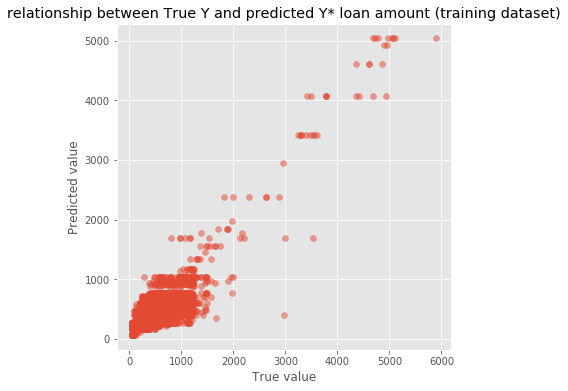

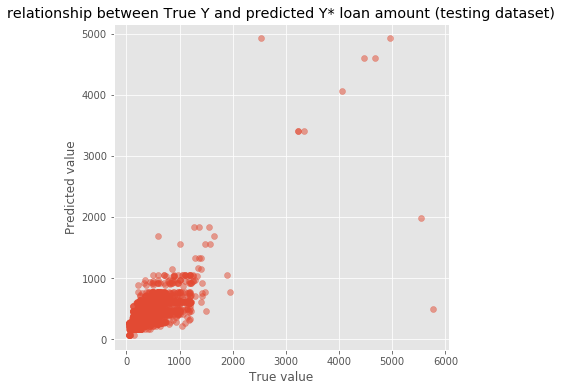

In [27]:
# plotting a graph of the true values vs the predicted values for the training and test datasets
def plot_y_yhat_scatter(y_actual,y_predicted,train_test):
    fig = plt.figure(figsize=(6, 6))
    plt.scatter(y_actual, y_predicted, alpha=0.5)
    plt.xlabel('True value')
    plt.ylabel('Predicted value')
    plt.title("relationship between True Y and predicted Y* loan amount ({0} dataset)".format(train_test))
    plt.show()
    
plot_y_yhat_scatter(y_train, trained_regressor.predict(X_train),train_test = "training")
plot_y_yhat_scatter(y_test, trained_regressor.predict(X_test),train_test = "testing")


## 5. Feature Importance
<a id='featureimportance'></a>

We can look at which features are driving our model's predictions by examining the feature importance. Although we do not have the coefficients provided by a linear regression, we can analyze what percentage of the overall variance was explained by a given feature. This is known as feature importance. 

An important but counter-intuitive thing to note here is that the magnitude of the 'importance' is not indicative of how important the feature is, only the order matters!

For example,
- feature A has an importance of 0.5 
- feature B has an importance of 0.25. 

Then all we can take away is that feature A is more explains more variance then feautre B, **not** that feature A explains twice as much as feature B. 

In [28]:
# Get the feature importances from our final trained model...
importances = trained_regressor.feature_importances_

# Find the indices of the feature importances in descending order
indices = np.argsort(importances)[::-1]

# Print the important features in descending order
print('Feature Ranking:')
for f in range(len(importances)):
    print("%d. feature %s (%f)" % (f + 1, X_train.columns[indices[f]], importances[indices[f]]))

Feature Ranking:
1. feature bc_partner_OAF_high (0.526394)
2. feature terms.repayment_term (0.135870)
3. feature days_to_fund (0.112209)
4. feature num_partner_countries (0.050301)
5. feature bc_partner_OAF_low (0.043363)
6. feature partner_dollar_amount (0.040926)
7. feature posted_year (0.029837)
8. feature partner_delinquency_rate (0.010638)
9. feature bc_partner_HIHEA (0.010586)
10. feature hours_to_fund (0.009855)
11. feature top_partner_id (0.007013)
12. feature more_one_partner_country (0.005540)
13. feature sector_Agriculture (0.005316)
14. feature posted_month (0.003855)
15. feature children_int (0.002451)
16. feature tag_#Schooling (0.001961)
17. feature num_tags (0.001847)
18. feature married (0.000589)
19. feature sector_Personal Use (0.000435)
20. feature sector_Health (0.000398)
21. feature sector_Wholesale (0.000385)
22. feature pct_female (0.000233)
23. feature age_int (0.000000)
24. feature tag_#Woman Owned Biz (0.000000)
25. feature parent (0.000000)
26. feature tag_#

What is interesting here is that there is not a very clear relationship between any single feature and the loan_amount. The most important feature borrower count for One Acre Fund during their high loan period - this is very specific to just a small subset of the data. 

However the aggregate of these features together into the decision leads to effective predictions (R^2 ~ 0.57). This is a testament to the predictive power of decisions trees!

## 6. Homework
<a id='homework'></a>

### Predicting Days to Fund
- Repeat the DecisionTreeRegressor method with a new target feature: days_to_fund.
- Use GridSearch to tune the parameters. 
- Determine the most important features and discuss which features are intuitive or a surprise and why. 

In [60]:
y = df['days_to_fund']
# drop returns a copy of the DataFrame with the specified columns removed.  
X = cols.drop('days_to_fund', axis=1)

In [64]:
# Create X_train, y_train, X_test and y_test where the y value is the days_to_fund feature. 
# Try using test_train_split function imported from sklearn

Remember the three basic steps:
- step 1: Initiate the algorithm
- step 2: Fit the algorithm to the training data
- step 3: Evaluate the algorithm performance

In [62]:
# Use the DecisionTreeRegressor method to predict the days_to_fund

In [63]:
# GridSearchCV to tune parameters

In [61]:
# Use the model attribute important_features_ to examine the feature importance. 

## 7. Advanced Material: Optimising the algorithm
<a id='AdvancedCV'></a>

### K-folds example for finding optimal parameters 

K-folds is a method of evaluating and tuning a model on the given dataset without overfitting to either the training dataset or the testing dataset. It finds the optimal balance between bias and variance in the model. 

For example, first look at how the model performs on the training and test datasets while varying the max tree depth. 

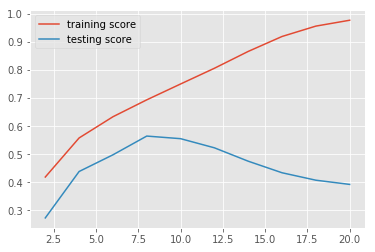

In [40]:
# define max depth range
depth_range = range(2,22,2)

# initialize empty arrays to store the results
scores_train = np.zeros(len(depth_range))
scores_test = np.zeros(len(depth_range))

for i in range(len(depth_range)):
    # train DTR with given max depth
    dt_regressor = DecisionTreeRegressor(max_depth=depth_range[i], random_state=42)
    model = dt_regressor.fit(X_train, y_train)
    # evaluate on both training and test datasets
    scores_train[i] = model.score(X_train, y_train)
    scores_test[i] = model.score(X_test, y_test)

# plot the results on the same graph
plt.plot(depth_range, scores_train, label='training score')
plt.plot(depth_range, scores_test, label='testing score')
plt.legend(loc='best')
plt.show()

As we increase the depth:
- The training score increases
- But the testing score decreases

Once the test score starts decreasing, this indicates that the model is overfitting. 

Here we could be tempted to say that the optimal depth is approximately 8 as this corresponds to the maximum score for the testing data. **However this is not always the case**. The test set is just random fixed subset of data so choosing the optimal parameter here would be overfitting to the testset. 

This is where K-Folds cross validation comes in! This method does the following:
- Splits the dataset K equal random subsests
- Trains the data on K-1 subsets
- Evaluates performance on Kth left out subset
- Stores evaluation metric
- Repeats for K times for each random subset

Therefore if K = 5, the algorithm trains 5 times. Each time it holds out a 5th of the data, trains on the other 4/5ths and then evaluates the performance on the held out 5th. 

Here is an example of how the cross validation score changes with maximum tree depth

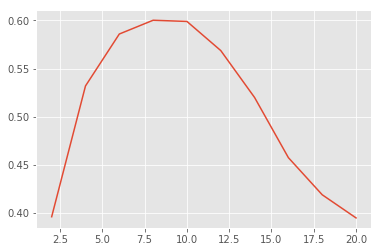

In [41]:
# initialize empty array to store results
scores_cv = np.empty(len(depth_range))
for i in range(len(depth_range)):
    # initialize model
    dt_regressor = DecisionTreeRegressor(max_depth=depth_range[i], random_state=42)
    # calculate the cross val scores. This returns an array where each element corresponds to the performance on each k-fold.
    cv_scores = cross_val_score(dt_regressor, X_train, y_train,cv=5, n_jobs=-1)
    # calculate mean cross validation score and save
    scores_cv[i] = np.mean(cv_scores)
# plot results
plt.plot(depth_range, scores_cv)
plt.show()

Again we see the same general trend of the score increasing intially and then dropping off. From this curve, the optimal max_depth would be between 8 and 10.

### GridSearchCV (CV = cross validation)
Above we were looking at a single parameter. However, to increase performance we should try adjusting several parameters. 

Sklearn's GridSearchCV uses the cross-validation above to assess the performance of **each possible permutation** of the hyper-parameters that you specify. For this reason, care should be taken to choose the correct range of parameters to search through as adding an additional parameter can increase the search time exponentially.

It then returns a model initialised with the optimal parameters.

In [55]:
from sklearn.model_selection import GridSearchCV

parameters = {'min_impurity_decrease': [.1, 0.01, 0.],
              'max_depth': [None, 5, 8, 10]}
# initialize model
gridrf = DecisionTreeRegressor()
# set up and fit gridsearchCV
grid_rf = GridSearchCV(gridrf, parameters)
grid_rf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'min_impurity_decrease': [0.1, 0.01, 0.0], 'max_depth': [None, 5, 8, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [56]:
# evaluate the tuned model
trained_regressor = train_score_regressor(sklearn_regressor = DecisionTreeRegressor,
                                          X_train = X_train, y_train = y_train, 
                                          X_test = X_test, y_test = y_test, 
                                          model_parameters = grid_rf.best_estimator_.get_params())

Train score: 0.693913258576
Test score: 0.566703719447


We can also check the variation in the mean cross validation score across the different parameter permutations in the grid search. This allows us to see which parameters have the biggest impact on performance. 

In this particulatr case, it shows the max_depth has the biggest impact.

In [57]:
# get the cross validation mean score and associated std across the K folds
means = grid_rf.cv_results_['mean_test_score']
stds = grid_rf.cv_results_['std_test_score']
# print the mean, std and parameters for each permutation
for mean, std, params in zip(means, stds, grid_rf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

0.363 (+/-0.101) for {'min_impurity_decrease': 0.1, 'max_depth': None}
0.368 (+/-0.114) for {'min_impurity_decrease': 0.01, 'max_depth': None}
0.340 (+/-0.141) for {'min_impurity_decrease': 0.0, 'max_depth': None}
0.572 (+/-0.037) for {'min_impurity_decrease': 0.1, 'max_depth': 5}
0.573 (+/-0.038) for {'min_impurity_decrease': 0.01, 'max_depth': 5}
0.555 (+/-0.064) for {'min_impurity_decrease': 0.0, 'max_depth': 5}
0.613 (+/-0.002) for {'min_impurity_decrease': 0.1, 'max_depth': 8}
0.611 (+/-0.003) for {'min_impurity_decrease': 0.01, 'max_depth': 8}
0.611 (+/-0.006) for {'min_impurity_decrease': 0.0, 'max_depth': 8}
0.591 (+/-0.047) for {'min_impurity_decrease': 0.1, 'max_depth': 10}
0.605 (+/-0.024) for {'min_impurity_decrease': 0.01, 'max_depth': 10}
0.593 (+/-0.051) for {'min_impurity_decrease': 0.0, 'max_depth': 10}
